# Pneumonia Classifier

In this notebook, we will experiment with training a classifier model to classify chest X-ray images as either **Normal** or **Pneumonia**.  
We will explore various approaches including:
```bash
* Conventional machine learning: SVM
* Custom convolutional neural networks (CNNs)
* Pretrained models
    * vgg16
    * efficientnet-b0
    * resnet18
    * Vision Transformers (ViT).  
```
* For training, **NVIDA GeForce GTX 1070 Ti** is used.  
* Finally, we will compare the performance of all models, their accuracy on test dataset and training time.

---

## Table of Contents
1. Imports
2. Dataset Overview
3. Data Loading
4. Visualizing Sample Images
5. Helper Functions
6. Model Training and Evaluation
    - 1. Conventional Machine Learning
    - 2. Custom CNN
    - 3. Pretrained Models
7. Models Comparison
8. Conclusion

## Imports

In [1]:
import os
import time
import copy
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# For EfficientNet
from efficientnet_pytorch import EfficientNet

# For Vision Transformer
import timm

**Device agnostic code**

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1070 Ti


In [5]:
!nvidia-smi

Fri Oct 11 14:31:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1070 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8             10W /  180W |       0MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset Overview  
We are using the [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset, which is organized into three main folders: `train`, `val` and `test`.  
Each of these contains subfolders for the two classes:
1. `PNEUMONIA`
2. `NORMAL`.

```bash
Dataset
 |- test
    |- NORMAL
    |- PNEUMONIA
 |- train
    |- NORMAL
    |- PNEUMONIA
 |- val
    |- NORMAL
    |- PNEUMONIA
```

* **Total Images:** 5,863 X-Ray images (JPEG)
* **Categories:** 2 (PNEUMONIA/NORMAL)
* **Number of Images in Training set:** 
   * NORMAL: 1341
   * PNEUMONIA: 3875

## Data Loading and Visualization  

In [4]:
data_dir = '../data'

# Define the transformations for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

In [6]:
print(f"Number of Train Images: {len(image_datasets['train'])}")
print(f"Number of Val Images: {len(image_datasets['val'])}")
print(f"Number of Test Images: {len(image_datasets['test'])}")   

Number of Train Images: 5216
Number of Val Images: 16
Number of Test Images: 624


**Create DataLoaders**

In [7]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                             shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")

Classes: ['NORMAL', 'PNEUMONIA']


## Visualizing Sample Images

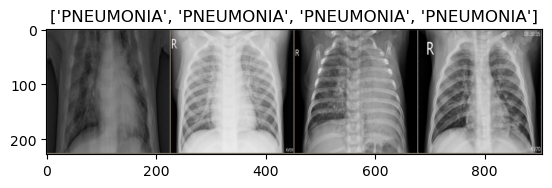

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
inputs, classes_batch = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes_batch[:4]])

## Helper Functions

In [9]:
# Function to print training time
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time: .3f} seconds")
    return total_time

In [74]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # To store loss and accuracy
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase} || Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    return model, history, time_elapsed

**Function to evaluate the model**

In [75]:
def evaluate_model(model, dataloader, phase='test'):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=phase):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n\033[1mAccuracy for {phase} Set:\033[0m {accuracy:.4f}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.title(f'Confusion Matrix for {phase} Set', fontsize=16, fontweight='bold')
    plt.show()
    return accuracy

## Model Training and Evaluation  
We will explore the following models:
```bash
1. Support Vector Machine
2. Custom CNN
3. Pretrained CNN Models
    1. VGG16
    2. EfficientNet-B0
    3. Resnet-18
    4. ViT-Base-Patch16-224
4. Vision Transformers (ViT)
```

## 1. Conventional Machine Learning  (Support Vector Machine)
* Features will be extracted using Histogram of Oriented Gradients (HOG) 
* Then we will do training on Support Vector Machine (SVM).

In [12]:
from skimage.feature import hog
from sklearn.svm import SVC

**Function to extract HOG features**

In [ ]:
def extract_hog_features(dataset):
    features = []
    labels = []
    for inputs, labels_batch in tqdm(dataloaders[dataset], desc=f'Extracting HOG for {dataset}'):
        for img, label in zip(inputs, labels_batch):
            img = img.numpy().transpose(1, 2, 0)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            hog_feat = hog(img, pixels_per_cell=(16, 16),
                           cells_per_block=(2, 2),
                           feature_vector=True)
            features.append(hog_feat)
            labels.append(label)
    return np.array(features), np.array(labels)

In [13]:
# Extract features
train_features, train_labels = extract_hog_features('train')
val_features, val_labels = extract_hog_features('val')
test_features, test_labels = extract_hog_features('test')

Extracting HOG for test: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


**SVM Training**

In [14]:
svm_clf = SVC(kernel='linear')

since = timer()

svm_clf.fit(train_features, train_labels)

end = timer()

total_time = end - since

train_time_svm = total_time
print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')

Training complete in 0m 19s


**Evaluation**


Accuracy for Test Set: 0.7532



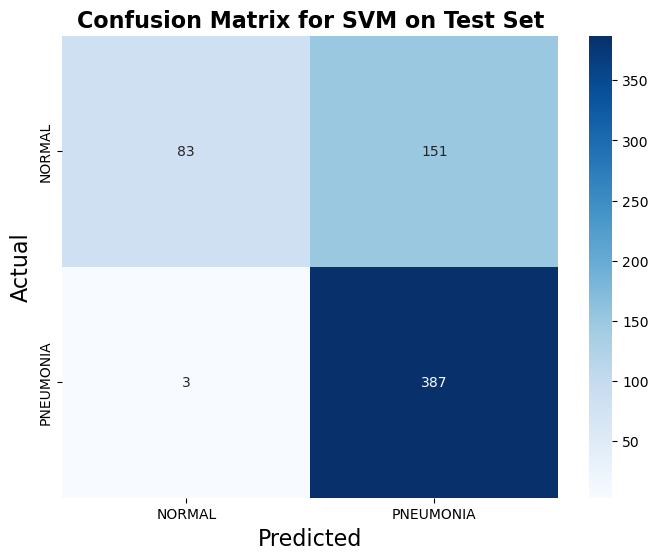

In [16]:
# Classification Report
# print("SVM Classification Report:")
# print(classification_report(test_labels, test_preds, target_names=class_names))

test_preds = svm_clf.predict(test_features)
test_acc_svm = accuracy_score(test_labels, test_preds)
print(f"\n\033[1mAccuracy for Test Set:\033[0m {test_acc_svm:.4f}\n")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual', fontsize=16)
plt.xlabel('Predicted', fontsize=16)
plt.title('Confusion Matrix for SVM on Test Set', fontsize=16, fontweight='bold')
plt.show()

---

## 2. Custom CNN  
Define and train a custom CNN for image classification

In [17]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 3x224x224
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # 32x112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # 64x56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # 128x28x28
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )
        """
        The self.classifier in CustomCNN has nn.Linear(128 * 28 * 28, 512). Depending on the input size and the operations in the network, the dimensionality of the feature map might not match this shape. You can print the feature map size right before the self.classifier to ensure compatibility.
        """
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [18]:
# Initialize the model
custom_cnn = CustomCNN(num_classes=2)
custom_cnn = custom_cnn.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn.parameters(), lr=1e-4)

# Define scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

**Train the model**

In [19]:
custom_cnn, history_custom_cnn, time_custom_cnn = train_model(custom_cnn, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------


train: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]


train || Loss: 0.1901 | Accuracy: 0.9258


val: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


val || Loss: 0.4699 | Accuracy: 0.7500

Epoch 2/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.13it/s]


train || Loss: 0.1097 | Accuracy: 0.9594


val: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


val || Loss: 0.8570 | Accuracy: 0.5625

Epoch 3/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.08it/s]


train || Loss: 0.0809 | Accuracy: 0.9697


val: 100%|██████████| 1/1 [00:06<00:00,  6.52s/it]


val || Loss: 0.7885 | Accuracy: 0.6250

Epoch 4/25
----------


train: 100%|██████████| 163/163 [00:53<00:00,  3.07it/s]


train || Loss: 0.0664 | Accuracy: 0.9762


val: 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


val || Loss: 0.2150 | Accuracy: 0.8125

Epoch 5/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.08it/s]


train || Loss: 0.0567 | Accuracy: 0.9795


val: 100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


val || Loss: 0.1596 | Accuracy: 0.9375

Epoch 6/25
----------


train: 100%|██████████| 163/163 [00:53<00:00,  3.05it/s]


train || Loss: 0.0504 | Accuracy: 0.9808


val: 100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


val || Loss: 0.1922 | Accuracy: 0.9375

Epoch 7/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.12it/s]


train || Loss: 0.0467 | Accuracy: 0.9812


val: 100%|██████████| 1/1 [00:06<00:00,  6.52s/it]


val || Loss: 0.0976 | Accuracy: 1.0000

Epoch 8/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.13it/s]


train || Loss: 0.0371 | Accuracy: 0.9872


val: 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


val || Loss: 0.2221 | Accuracy: 0.8750

Epoch 9/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.12it/s]


train || Loss: 0.0296 | Accuracy: 0.9895


val: 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]


val || Loss: 0.1929 | Accuracy: 0.9375

Epoch 10/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.12it/s]


train || Loss: 0.0263 | Accuracy: 0.9900


val: 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]


val || Loss: 0.2312 | Accuracy: 0.9375

Epoch 11/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.15it/s]


train || Loss: 0.0237 | Accuracy: 0.9921


val: 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


val || Loss: 0.1483 | Accuracy: 0.9375

Epoch 12/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.19it/s]


train || Loss: 0.0227 | Accuracy: 0.9912


val: 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]


val || Loss: 0.1487 | Accuracy: 0.9375

Epoch 13/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.18it/s]


train || Loss: 0.0225 | Accuracy: 0.9925


val: 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


val || Loss: 0.1760 | Accuracy: 0.9375

Epoch 14/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.16it/s]


train || Loss: 0.0197 | Accuracy: 0.9937


val: 100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


val || Loss: 0.1231 | Accuracy: 0.9375

Epoch 15/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.14it/s]


train || Loss: 0.0192 | Accuracy: 0.9931


val: 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


val || Loss: 0.1438 | Accuracy: 0.9375

Epoch 16/25
----------


train: 100%|██████████| 163/163 [00:53<00:00,  3.05it/s]


train || Loss: 0.0182 | Accuracy: 0.9931


val: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


val || Loss: 0.1545 | Accuracy: 0.9375

Epoch 17/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.13it/s]


train || Loss: 0.0177 | Accuracy: 0.9939


val: 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


val || Loss: 0.1516 | Accuracy: 0.9375

Epoch 18/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.17it/s]


train || Loss: 0.0193 | Accuracy: 0.9946


val: 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


val || Loss: 0.1629 | Accuracy: 0.9375

Epoch 19/25
----------


train: 100%|██████████| 163/163 [00:50<00:00,  3.20it/s]


train || Loss: 0.0169 | Accuracy: 0.9946


val: 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


val || Loss: 0.1588 | Accuracy: 0.9375

Epoch 20/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.11it/s]


train || Loss: 0.0172 | Accuracy: 0.9942


val: 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


val || Loss: 0.1595 | Accuracy: 0.9375

Epoch 21/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.17it/s]


train || Loss: 0.0183 | Accuracy: 0.9933


val: 100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


val || Loss: 0.1516 | Accuracy: 0.9375

Epoch 22/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.16it/s]


train || Loss: 0.0174 | Accuracy: 0.9935


val: 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]


val || Loss: 0.1529 | Accuracy: 0.9375

Epoch 23/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.14it/s]


train || Loss: 0.0174 | Accuracy: 0.9937


val: 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


val || Loss: 0.1530 | Accuracy: 0.9375

Epoch 24/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.15it/s]


train || Loss: 0.0174 | Accuracy: 0.9941


val: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


val || Loss: 0.1525 | Accuracy: 0.9375

Epoch 25/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.18it/s]


train || Loss: 0.0173 | Accuracy: 0.9944


val: 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]

val || Loss: 0.1541 | Accuracy: 0.9375

Training complete in 24m 33s
Best val Acc: 1.000000


**Save the model**

In [20]:
torch.save(custom_cnn.state_dict(), '../model/custom_cnn.pth')

**Plot Learning Curves**

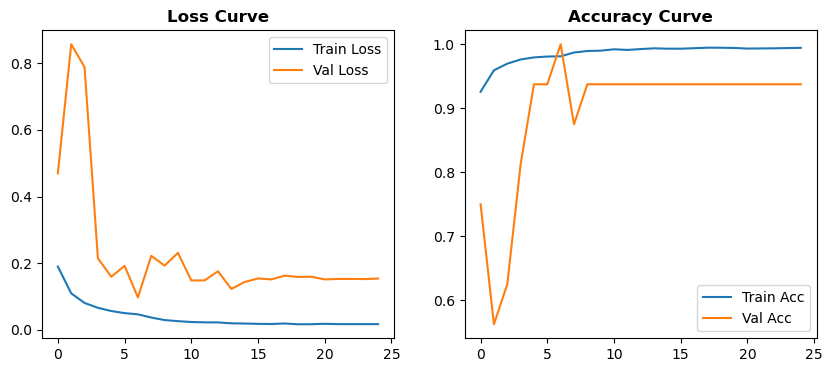

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_custom_cnn['train_loss'], label='Train Loss')
plt.plot(history_custom_cnn['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve', fontweight='bold')

plt.subplot(1,2,2)
plt.plot(history_custom_cnn['train_acc'], label='Train Acc')
plt.plot(history_custom_cnn['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy Curve', fontweight='bold')
plt.show()

**Evaluation on Test Set**

test: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Accuracy for test Set: 0.8013



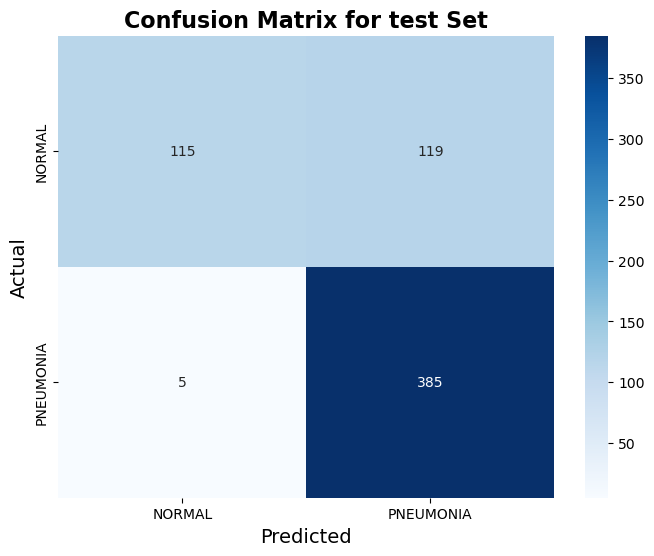

In [78]:
test_acc_custom_cnn = evaluate_model(custom_cnn, dataloaders['test'])

---

## 3. Pretrained Models  
Now, We will fine-tune several pretrained models like `VGG16`, `EfficientNet-B0`, `ResNet18` and `vit_base_patch16_224`.

### 3.1 VGG16

**Load pretrained VGG16 model**

In [26]:
vgg16 = models.vgg16(weights=True)

c:\Users\DIP Lab\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\DIP Lab/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [37:59<00:00, 243kB/s] 


In [24]:
# Freeze all layers
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the classifier
vgg16.classifier[6] = nn.Linear(4096, 2)
vgg16 = vgg16.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=1e-4)

# Define scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

**Train the model**

In [25]:
vgg16, history_vgg16, time_vgg16 = train_model(vgg16, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.11it/s]


train || Loss: 0.3590 | Accuracy: 0.8439


val: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


val || Loss: 0.3878 | Accuracy: 0.7500

Epoch 2/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.14it/s]


train || Loss: 0.2395 | Accuracy: 0.9041


val: 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]


val || Loss: 0.2840 | Accuracy: 0.9375

Epoch 3/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.18it/s]


train || Loss: 0.2136 | Accuracy: 0.9185


val: 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


val || Loss: 0.2524 | Accuracy: 0.9375

Epoch 4/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.13it/s]


train || Loss: 0.1959 | Accuracy: 0.9271


val: 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


val || Loss: 0.2544 | Accuracy: 0.8750

Epoch 5/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.12it/s]


train || Loss: 0.1910 | Accuracy: 0.9260


val: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


val || Loss: 0.2350 | Accuracy: 1.0000

Epoch 6/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.15it/s]


train || Loss: 0.1744 | Accuracy: 0.9337


val: 100%|██████████| 1/1 [00:08<00:00,  8.03s/it]


val || Loss: 0.2047 | Accuracy: 1.0000

Epoch 7/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.16it/s]


train || Loss: 0.1712 | Accuracy: 0.9331


val: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


val || Loss: 0.2178 | Accuracy: 1.0000

Epoch 8/25
----------


train: 100%|██████████| 163/163 [00:50<00:00,  3.20it/s]


train || Loss: 0.1685 | Accuracy: 0.9329


val: 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


val || Loss: 0.2192 | Accuracy: 1.0000

Epoch 9/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.19it/s]


train || Loss: 0.1657 | Accuracy: 0.9362


val: 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


val || Loss: 0.2086 | Accuracy: 1.0000

Epoch 10/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.19it/s]


train || Loss: 0.1686 | Accuracy: 0.9356


val: 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]


val || Loss: 0.2108 | Accuracy: 1.0000

Epoch 11/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.16it/s]


train || Loss: 0.1657 | Accuracy: 0.9358


val: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


val || Loss: 0.2215 | Accuracy: 0.9375

Epoch 12/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.16it/s]


train || Loss: 0.1608 | Accuracy: 0.9383


val: 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


val || Loss: 0.2110 | Accuracy: 1.0000

Epoch 13/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.14it/s]


train || Loss: 0.1632 | Accuracy: 0.9363


val: 100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


val || Loss: 0.2047 | Accuracy: 1.0000

Epoch 14/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.16it/s]


train || Loss: 0.1663 | Accuracy: 0.9358


val: 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


val || Loss: 0.2077 | Accuracy: 1.0000

Epoch 15/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.15it/s]


train || Loss: 0.1628 | Accuracy: 0.9379


val: 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


val || Loss: 0.2082 | Accuracy: 1.0000

Epoch 16/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.15it/s]


train || Loss: 0.1603 | Accuracy: 0.9387


val: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


val || Loss: 0.2088 | Accuracy: 1.0000

Epoch 17/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.18it/s]


train || Loss: 0.1684 | Accuracy: 0.9356


val: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


val || Loss: 0.2080 | Accuracy: 1.0000

Epoch 18/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.17it/s]


train || Loss: 0.1645 | Accuracy: 0.9381


val: 100%|██████████| 1/1 [00:06<00:00,  6.40s/it]


val || Loss: 0.2083 | Accuracy: 1.0000

Epoch 19/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.15it/s]


train || Loss: 0.1616 | Accuracy: 0.9358


val: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


val || Loss: 0.2073 | Accuracy: 1.0000

Epoch 20/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.17it/s]


train || Loss: 0.1614 | Accuracy: 0.9363


val: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


val || Loss: 0.2065 | Accuracy: 1.0000

Epoch 21/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.17it/s]


train || Loss: 0.1648 | Accuracy: 0.9371


val: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


val || Loss: 0.2073 | Accuracy: 1.0000

Epoch 22/25
----------


train: 100%|██████████| 163/163 [00:52<00:00,  3.08it/s]


train || Loss: 0.1649 | Accuracy: 0.9365


val: 100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


val || Loss: 0.2073 | Accuracy: 1.0000

Epoch 23/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.15it/s]


train || Loss: 0.1600 | Accuracy: 0.9413


val: 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


val || Loss: 0.2073 | Accuracy: 1.0000

Epoch 24/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.18it/s]


train || Loss: 0.1612 | Accuracy: 0.9371


val: 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]


val || Loss: 0.2073 | Accuracy: 1.0000

Epoch 25/25
----------


train: 100%|██████████| 163/163 [00:51<00:00,  3.20it/s]


train || Loss: 0.1691 | Accuracy: 0.9314


val: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]

val || Loss: 0.2073 | Accuracy: 1.0000

Training complete in 24m 12s
Best val Acc: 1.000000


**Save the model**

In [26]:
torch.save(vgg16.state_dict(), '../model/vgg16.pth')

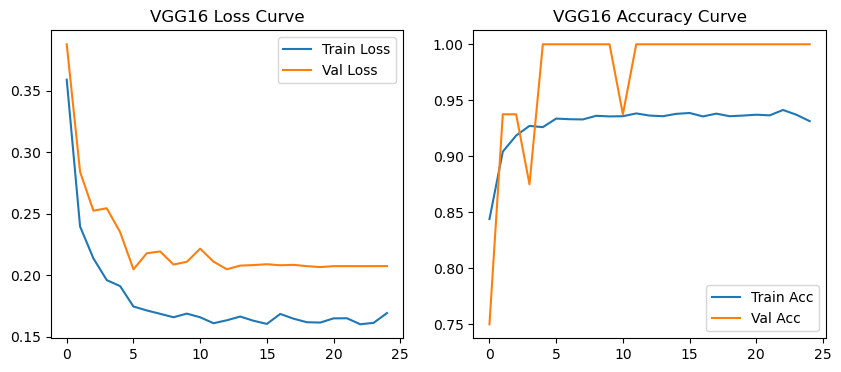

In [27]:
# Plot Learning Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_vgg16['train_loss'], label='Train Loss')
plt.plot(history_vgg16['val_loss'], label='Val Loss')
plt.legend()
plt.title('VGG16 Loss Curve')

plt.subplot(1,2,2)
plt.plot(history_vgg16['train_acc'], label='Train Acc')
plt.plot(history_vgg16['val_acc'], label='Val Acc')
plt.legend()
plt.title('VGG16 Accuracy Curve')
plt.show()

**Evaluate model on Test Set**

test: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]



Accuracy for test Set: 0.7901



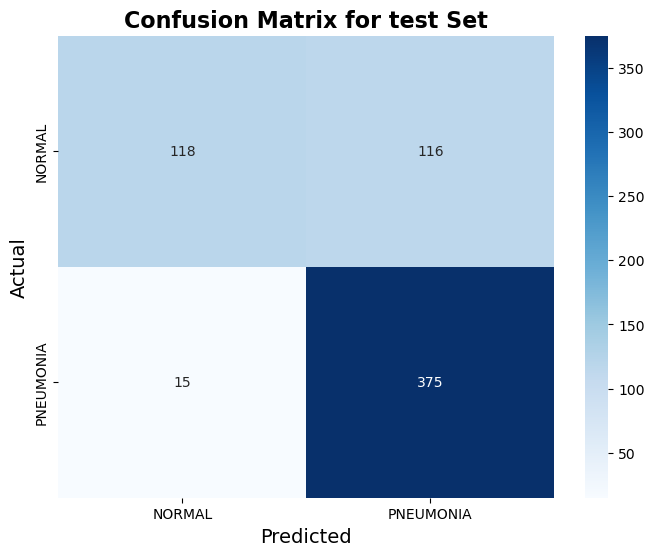

In [79]:
test_acc_vgg16 = evaluate_model(vgg16, dataloaders['test'], phase='test')

---

### 3.2 EfficientNet-B0

In [29]:
# Install efficientnet_pytorch if not installed
# !pip install efficientnet_pytorch

# from efficientnet_pytorch import EfficientNet

**Load pretrained EfficientNet**

In [35]:
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\DIP Lab/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [02:08<00:00, 167kB/s] 

Loaded pretrained weights for efficientnet-b0


In [31]:
# Modify the classifier
efficientnet._fc = nn.Linear(efficientnet._fc.in_features, 2)
efficientnet = efficientnet.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=1e-4)

# Define scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

**Train the model**

In [32]:
efficientnet, history_efficientnet, time_efficientnet = train_model(efficientnet, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.54it/s]


train || Loss: 0.1755 | Accuracy: 0.9448


val: 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


val || Loss: 0.4301 | Accuracy: 0.5625

Epoch 2/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.53it/s]


train || Loss: 0.0412 | Accuracy: 0.9879


val: 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]


val || Loss: 0.1534 | Accuracy: 0.9375

Epoch 3/25
----------


train: 100%|██████████| 163/163 [01:03<00:00,  2.57it/s]


train || Loss: 0.0192 | Accuracy: 0.9948


val: 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


val || Loss: 0.1524 | Accuracy: 0.9375

Epoch 4/25
----------


train: 100%|██████████| 163/163 [01:03<00:00,  2.56it/s]


train || Loss: 0.0129 | Accuracy: 0.9965


val: 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]


val || Loss: 0.2104 | Accuracy: 0.9375

Epoch 5/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.54it/s]


train || Loss: 0.0144 | Accuracy: 0.9964


val: 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


val || Loss: 0.0133 | Accuracy: 1.0000

Epoch 6/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.53it/s]


train || Loss: 0.0073 | Accuracy: 0.9981


val: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


val || Loss: 0.0058 | Accuracy: 1.0000

Epoch 7/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.54it/s]


train || Loss: 0.0077 | Accuracy: 0.9981


val: 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


val || Loss: 0.0663 | Accuracy: 1.0000

Epoch 8/25
----------


train: 100%|██████████| 163/163 [01:03<00:00,  2.55it/s]


train || Loss: 0.0039 | Accuracy: 0.9994


val: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]


val || Loss: 0.0148 | Accuracy: 1.0000

Epoch 9/25
----------


train: 100%|██████████| 163/163 [01:03<00:00,  2.56it/s]


train || Loss: 0.0034 | Accuracy: 0.9994


val: 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


val || Loss: 0.0122 | Accuracy: 1.0000

Epoch 10/25
----------


train: 100%|██████████| 163/163 [01:03<00:00,  2.55it/s]


train || Loss: 0.0042 | Accuracy: 0.9988


val: 100%|██████████| 1/1 [07:48<00:00, 468.73s/it]


val || Loss: 0.0114 | Accuracy: 1.0000

Epoch 11/25
----------


train: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]


train || Loss: 0.0025 | Accuracy: 0.9996


val: 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]


val || Loss: 0.0081 | Accuracy: 1.0000

Epoch 12/25
----------


train: 100%|██████████| 163/163 [01:07<00:00,  2.40it/s]


train || Loss: 0.0017 | Accuracy: 0.9998


val: 100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


val || Loss: 0.0100 | Accuracy: 1.0000

Epoch 13/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.54it/s]


train || Loss: 0.0041 | Accuracy: 0.9988


val: 100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


val || Loss: 0.0172 | Accuracy: 1.0000

Epoch 14/25
----------


train: 100%|██████████| 163/163 [01:03<00:00,  2.55it/s]


train || Loss: 0.0023 | Accuracy: 0.9994


val: 100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


val || Loss: 0.0060 | Accuracy: 1.0000

Epoch 15/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.53it/s]


train || Loss: 0.0027 | Accuracy: 0.9990


val: 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


val || Loss: 0.0058 | Accuracy: 1.0000

Epoch 16/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.52it/s]


train || Loss: 0.0019 | Accuracy: 0.9998


val: 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


val || Loss: 0.0060 | Accuracy: 1.0000

Epoch 17/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.55it/s]


train || Loss: 0.0018 | Accuracy: 0.9994


val: 100%|██████████| 1/1 [00:06<00:00,  6.69s/it]


val || Loss: 0.0060 | Accuracy: 1.0000

Epoch 18/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.55it/s]


train || Loss: 0.0026 | Accuracy: 0.9996


val: 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


val || Loss: 0.0062 | Accuracy: 1.0000

Epoch 19/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.53it/s]


train || Loss: 0.0029 | Accuracy: 0.9994


val: 100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


val || Loss: 0.0072 | Accuracy: 1.0000

Epoch 20/25
----------


train: 100%|██████████| 163/163 [01:03<00:00,  2.56it/s]


train || Loss: 0.0020 | Accuracy: 0.9994


val: 100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


val || Loss: 0.0065 | Accuracy: 1.0000

Epoch 21/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.53it/s]


train || Loss: 0.0028 | Accuracy: 0.9994


val: 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


val || Loss: 0.0069 | Accuracy: 1.0000

Epoch 22/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.53it/s]


train || Loss: 0.0019 | Accuracy: 0.9996


val: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


val || Loss: 0.0065 | Accuracy: 1.0000

Epoch 23/25
----------


train: 100%|██████████| 163/163 [01:03<00:00,  2.55it/s]


train || Loss: 0.0016 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.52s/it]


val || Loss: 0.0062 | Accuracy: 1.0000

Epoch 24/25
----------


train: 100%|██████████| 163/163 [01:03<00:00,  2.55it/s]


train || Loss: 0.0023 | Accuracy: 0.9996


val: 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


val || Loss: 0.0064 | Accuracy: 1.0000

Epoch 25/25
----------


train: 100%|██████████| 163/163 [01:04<00:00,  2.54it/s]


train || Loss: 0.0013 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]

val || Loss: 0.0061 | Accuracy: 1.0000

Training complete in 37m 25s
Best val Acc: 1.000000


**Save the model**

In [33]:
torch.save(efficientnet.state_dict(), '../model/efficientnet-b0.pth')

**Plot Learning Curves**

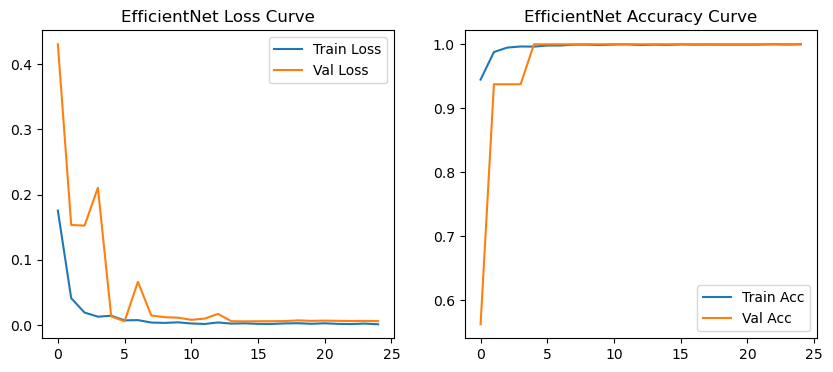

In [34]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_efficientnet['train_loss'], label='Train Loss')
plt.plot(history_efficientnet['val_loss'], label='Val Loss')
plt.legend()
plt.title('EfficientNet Loss Curve')

plt.subplot(1,2,2)
plt.plot(history_efficientnet['train_acc'], label='Train Acc')
plt.plot(history_efficientnet['val_acc'], label='Val Acc')
plt.legend()
plt.title('EfficientNet Accuracy Curve')
plt.show()

**Evaluation on Test Set**

test: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Accuracy for test Set: 0.8045



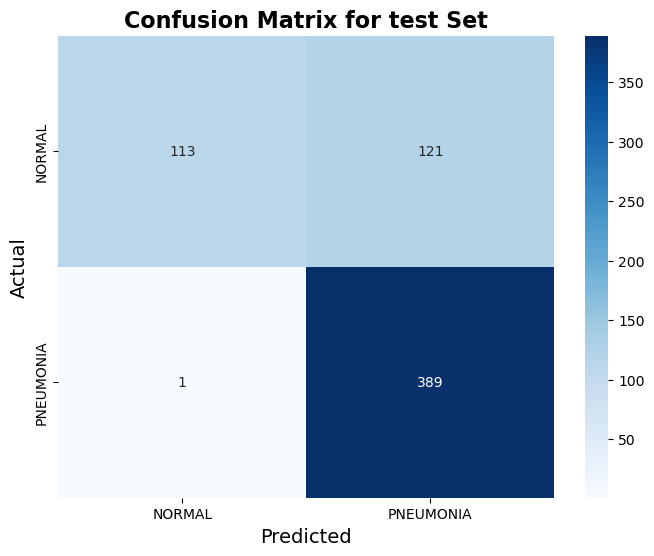

In [80]:
test_acc_efficientnet = evaluate_model(efficientnet, dataloaders['test'], phase='test')

---

### 3.3 ResNet18

**Load pretrained ResNet18**

In [41]:
resnet18 = models.resnet18(weights=True)

c:\Users\DIP Lab\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\DIP Lab/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [03:25<00:00, 228kB/s]


In [37]:
# Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the final layer
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)
resnet18 = resnet18.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=1e-4)

# Define scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

**Train the model**

In [38]:
# resnet18, history_resnet18 = train_model(resnet18, criterion, optimizer, scheduler, num_epochs=2)
resnet18, history_resnet18, time_resnet18 = train_model(resnet18, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]


train || Loss: 0.6305 | Accuracy: 0.6626


val: 100%|██████████| 1/1 [00:06<00:00,  6.21s/it]


val || Loss: 0.6170 | Accuracy: 0.6250

Epoch 2/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]


train || Loss: 0.3883 | Accuracy: 0.8292


val: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


val || Loss: 0.5431 | Accuracy: 0.6250

Epoch 3/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]


train || Loss: 0.3058 | Accuracy: 0.8888


val: 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


val || Loss: 0.5080 | Accuracy: 0.6250

Epoch 4/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]


train || Loss: 0.2616 | Accuracy: 0.9084


val: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


val || Loss: 0.5280 | Accuracy: 0.6250

Epoch 5/25
----------


train: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]


train || Loss: 0.2347 | Accuracy: 0.9155


val: 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


val || Loss: 0.4653 | Accuracy: 0.5625

Epoch 6/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.41it/s]


train || Loss: 0.2157 | Accuracy: 0.9206


val: 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


val || Loss: 0.4540 | Accuracy: 0.6250

Epoch 7/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]


train || Loss: 0.2052 | Accuracy: 0.9254


val: 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


val || Loss: 0.4382 | Accuracy: 0.6250

Epoch 8/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]


train || Loss: 0.1968 | Accuracy: 0.9304


val: 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]


val || Loss: 0.4429 | Accuracy: 0.6250

Epoch 9/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]


train || Loss: 0.1973 | Accuracy: 0.9294


val: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


val || Loss: 0.4350 | Accuracy: 0.6250

Epoch 10/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.41it/s]


train || Loss: 0.1966 | Accuracy: 0.9262


val: 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


val || Loss: 0.4779 | Accuracy: 0.6875

Epoch 11/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.38it/s]


train || Loss: 0.1938 | Accuracy: 0.9268


val: 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


val || Loss: 0.4514 | Accuracy: 0.6875

Epoch 12/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]


train || Loss: 0.1939 | Accuracy: 0.9237


val: 100%|██████████| 1/1 [00:06<00:00,  6.21s/it]


val || Loss: 0.4526 | Accuracy: 0.6250

Epoch 13/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]


train || Loss: 0.1951 | Accuracy: 0.9273


val: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


val || Loss: 0.4464 | Accuracy: 0.6250

Epoch 14/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]


train || Loss: 0.1946 | Accuracy: 0.9268


val: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


val || Loss: 0.4793 | Accuracy: 0.6875

Epoch 15/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]


train || Loss: 0.1892 | Accuracy: 0.9291


val: 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


val || Loss: 0.4861 | Accuracy: 0.6875

Epoch 16/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.38it/s]


train || Loss: 0.1935 | Accuracy: 0.9275


val: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


val || Loss: 0.4337 | Accuracy: 0.6250

Epoch 17/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]


train || Loss: 0.1883 | Accuracy: 0.9281


val: 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]


val || Loss: 0.4540 | Accuracy: 0.6875

Epoch 18/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]


train || Loss: 0.1950 | Accuracy: 0.9247


val: 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


val || Loss: 0.4383 | Accuracy: 0.6250

Epoch 19/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.41it/s]


train || Loss: 0.1896 | Accuracy: 0.9268


val: 100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


val || Loss: 0.4894 | Accuracy: 0.6875

Epoch 20/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.38it/s]


train || Loss: 0.1886 | Accuracy: 0.9273


val: 100%|██████████| 1/1 [00:06<00:00,  6.21s/it]


val || Loss: 0.4974 | Accuracy: 0.6250

Epoch 21/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.41it/s]


train || Loss: 0.1875 | Accuracy: 0.9291


val: 100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


val || Loss: 0.4765 | Accuracy: 0.6875

Epoch 22/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]


train || Loss: 0.1933 | Accuracy: 0.9279


val: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]


val || Loss: 0.4711 | Accuracy: 0.6875

Epoch 23/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.39it/s]


train || Loss: 0.1904 | Accuracy: 0.9314


val: 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


val || Loss: 0.4897 | Accuracy: 0.6875

Epoch 24/25
----------


train: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]


train || Loss: 0.1904 | Accuracy: 0.9293


val: 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


val || Loss: 0.4736 | Accuracy: 0.6875

Epoch 25/25
----------


train: 100%|██████████| 163/163 [00:48<00:00,  3.39it/s]


train || Loss: 0.1917 | Accuracy: 0.9277


val: 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]

val || Loss: 0.4741 | Accuracy: 0.6875

Training complete in 22m 39s
Best val Acc: 0.687500


**Save the model**

In [39]:
torch.save(resnet18.state_dict(), '../model/resnet18.pth')

**Plot Learning Curves**

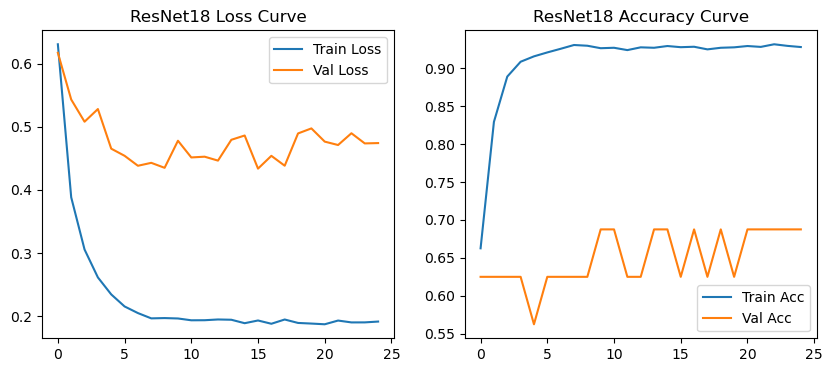

In [40]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_resnet18['train_loss'], label='Train Loss')
plt.plot(history_resnet18['val_loss'], label='Val Loss')
plt.legend()
plt.title('ResNet18 Loss Curve')

plt.subplot(1,2,2)
plt.plot(history_resnet18['train_acc'], label='Train Acc')
plt.plot(history_resnet18['val_acc'], label='Val Acc')
plt.legend()
plt.title('ResNet18 Accuracy Curve')
plt.show()

**Evaluate Model on Test Set**

test: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]



Accuracy for test Set: 0.8029



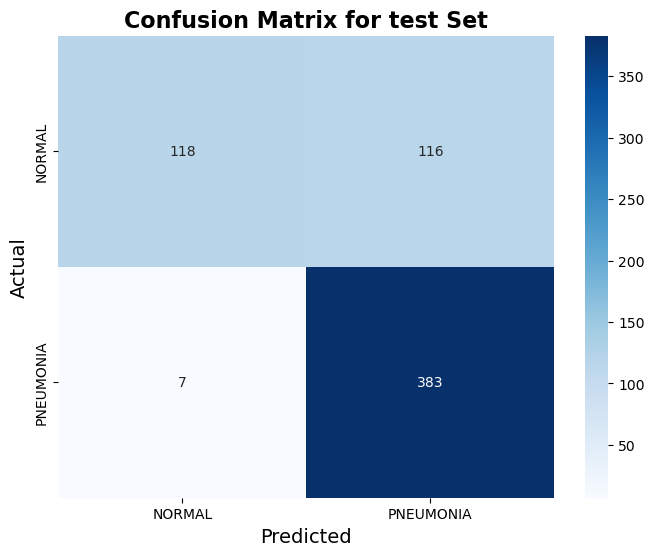

In [81]:
test_acc_resnet18 = evaluate_model(resnet18, dataloaders['test'], phase='test')

## 3.4. Vision Transformers (ViT)

The ViT model used here is `vit_base_patch16_224`. Other ViT models that can be used are;

`vit_small_patch16_224`   
`vit_large_patch16_224`    
`vit_base_patch32_224`  
`vit_large_patch32_224`   


---

**Define the ViT model**

In [49]:
class ViTModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ViTModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
    
    def forward(self, x):
        return self.vit(x)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

c:\Users\DIP Lab\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DIP Lab\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [44]:
# Initialize the ViT model
vit_model = ViTModel(num_classes=2)
vit_model = vit_model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

# Define scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

**Train the model**

In [45]:
vit_model, history_vit, time_vit = train_model(vit_model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------


train:   0%|          | 0/163 [00:00<?, ?it/s]c:\Users\DIP Lab\anaconda3\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
train: 100%|██████████| 163/163 [03:17<00:00,  1.21s/it]


train || Loss: 0.2900 | Accuracy: 0.8813


val: 100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


val || Loss: 1.3367 | Accuracy: 0.5625

Epoch 2/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0905 | Accuracy: 0.9666


val: 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


val || Loss: 1.1031 | Accuracy: 0.6875

Epoch 3/25
----------


train: 100%|██████████| 163/163 [03:17<00:00,  1.21s/it]


train || Loss: 0.0564 | Accuracy: 0.9799


val: 100%|██████████| 1/1 [00:06<00:00,  6.52s/it]


val || Loss: 0.3425 | Accuracy: 0.8750

Epoch 4/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0392 | Accuracy: 0.9864


val: 100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


val || Loss: 0.4128 | Accuracy: 0.8750

Epoch 5/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0389 | Accuracy: 0.9862


val: 100%|██████████| 1/1 [00:06<00:00,  6.52s/it]


val || Loss: 0.6789 | Accuracy: 0.7500

Epoch 6/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0128 | Accuracy: 0.9958


val: 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


val || Loss: 1.4893 | Accuracy: 0.6250

Epoch 7/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0299 | Accuracy: 0.9896


val: 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


val || Loss: 0.5140 | Accuracy: 0.8750

Epoch 8/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0035 | Accuracy: 0.9992


val: 100%|██████████| 1/1 [00:09<00:00,  9.25s/it]


val || Loss: 0.8501 | Accuracy: 0.7500

Epoch 9/25
----------


train: 100%|██████████| 163/163 [03:20<00:00,  1.23s/it]


train || Loss: 0.0007 | Accuracy: 0.9998


val: 100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


val || Loss: 1.0082 | Accuracy: 0.7500

Epoch 10/25
----------


train: 100%|██████████| 163/163 [03:20<00:00,  1.23s/it]


train || Loss: 0.0003 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:07<00:00,  7.40s/it]


val || Loss: 1.0503 | Accuracy: 0.7500

Epoch 11/25
----------


train: 100%|██████████| 163/163 [03:20<00:00,  1.23s/it]


train || Loss: 0.0002 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:07<00:00,  7.51s/it]


val || Loss: 1.0849 | Accuracy: 0.7500

Epoch 12/25
----------


train: 100%|██████████| 163/163 [03:20<00:00,  1.23s/it]


train || Loss: 0.0001 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


val || Loss: 1.1161 | Accuracy: 0.7500

Epoch 13/25
----------


train: 100%|██████████| 163/163 [03:21<00:00,  1.23s/it]


train || Loss: 0.0001 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


val || Loss: 1.1393 | Accuracy: 0.7500

Epoch 14/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0001 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


val || Loss: 1.1742 | Accuracy: 0.7500

Epoch 15/25
----------


train: 100%|██████████| 163/163 [03:19<00:00,  1.22s/it]


train || Loss: 0.0001 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.70s/it]


val || Loss: 1.1765 | Accuracy: 0.7500

Epoch 16/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0001 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.85s/it]


val || Loss: 1.1772 | Accuracy: 0.7500

Epoch 17/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0001 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


val || Loss: 1.1793 | Accuracy: 0.7500

Epoch 18/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0001 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


val || Loss: 1.1806 | Accuracy: 0.7500

Epoch 19/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0001 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


val || Loss: 1.1829 | Accuracy: 0.7500

Epoch 20/25
----------


train: 100%|██████████| 163/163 [03:19<00:00,  1.22s/it]


train || Loss: 0.0001 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


val || Loss: 1.1854 | Accuracy: 0.7500

Epoch 21/25
----------


train: 100%|██████████| 163/163 [03:19<00:00,  1.22s/it]


train || Loss: 0.0000 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.72s/it]


val || Loss: 1.1879 | Accuracy: 0.7500

Epoch 22/25
----------


train: 100%|██████████| 163/163 [03:19<00:00,  1.22s/it]


train || Loss: 0.0000 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


val || Loss: 1.1880 | Accuracy: 0.7500

Epoch 23/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0000 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


val || Loss: 1.1882 | Accuracy: 0.7500

Epoch 24/25
----------


train: 100%|██████████| 163/163 [03:18<00:00,  1.22s/it]


train || Loss: 0.0000 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


val || Loss: 1.1885 | Accuracy: 0.7500

Epoch 25/25
----------


train: 100%|██████████| 163/163 [03:19<00:00,  1.22s/it]


train || Loss: 0.0000 | Accuracy: 1.0000


val: 100%|██████████| 1/1 [00:06<00:00,  6.74s/it]

val || Loss: 1.1888 | Accuracy: 0.7500

Training complete in 85m 47s
Best val Acc: 0.875000


**Save model weights**

In [46]:
torch.save(vit_model.state_dict(), '../model/vit_model.pth')

**Plot learning Curves**

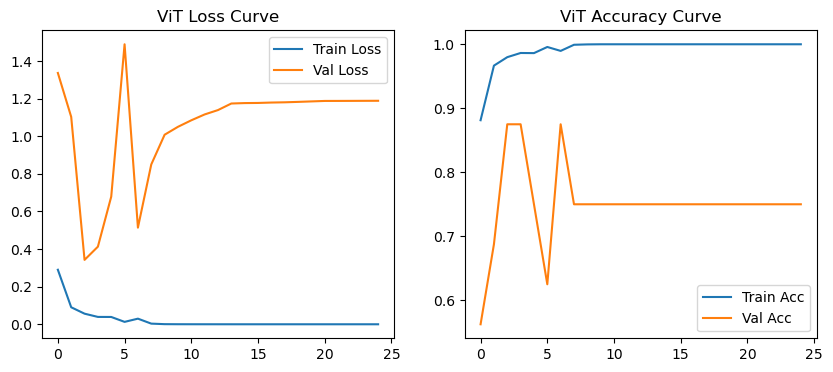

In [65]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_vit['train_loss'], label='Train Loss')
plt.plot(history_vit['val_loss'], label='Val Loss')
plt.legend()
plt.title('ViT Loss Curve')

plt.subplot(1,2,2)
plt.plot(history_vit['train_acc'], label='Train Acc')
plt.plot(history_vit['val_acc'], label='Val Acc')
plt.legend()
plt.title('ViT Accuracy Curve')
plt.show()

**Evaluate model on Test Set**

test: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Accuracy for test Set: 0.8574



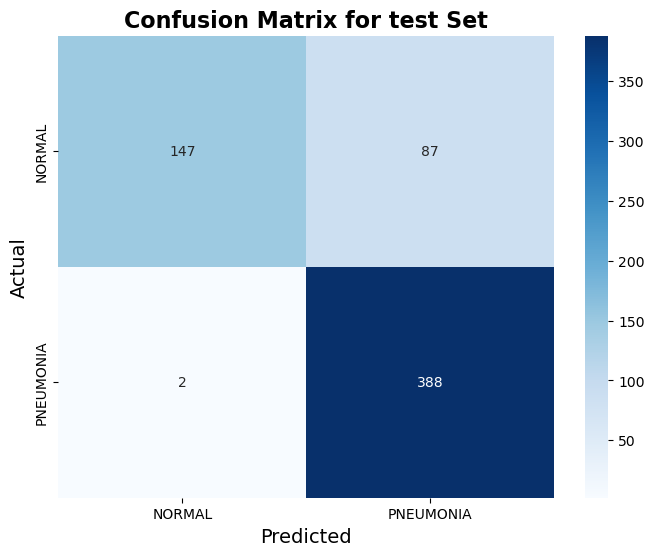

In [76]:
test_acc_vit= evaluate_model(vit_model, dataloaders['test'])

---

## Models Comparison

In [82]:
results = {
    'Model': ['SVM', 'Custom CNN', 'VGG16', 'EfficientNet-B0', 'ResNet18', 'ViT'],
    'Accuracy': [
        test_acc_svm,
        test_acc_custom_cnn,
        test_acc_vgg16,
        test_acc_efficientnet,
        test_acc_resnet18,
        test_acc_vit
    ],
    'Training Time': [
        train_time_svm,
        time_custom_cnn,
        time_vgg16,
        time_efficientnet,
        time_resnet18,
        time_vit
    ]
}

In [84]:
# Create DataFrame
df = pd.DataFrame(results)
print(df.to_string(index=False))

          Model  Accuracy  Training Time
            SVM  0.753205      19.144007
     Custom CNN  0.801282    1472.990343
          VGG16  0.790064    1451.518252
EfficientNet-B0  0.804487    2245.154869
       ResNet18  0.802885    1359.117294
            ViT  0.857372    5146.964665


**Bar chart for accuracy comparison**

C:\Users\DIP Lab\AppData\Local\Temp\ipykernel_12268\3547987657.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='Accuracy', palette='Blues_d')


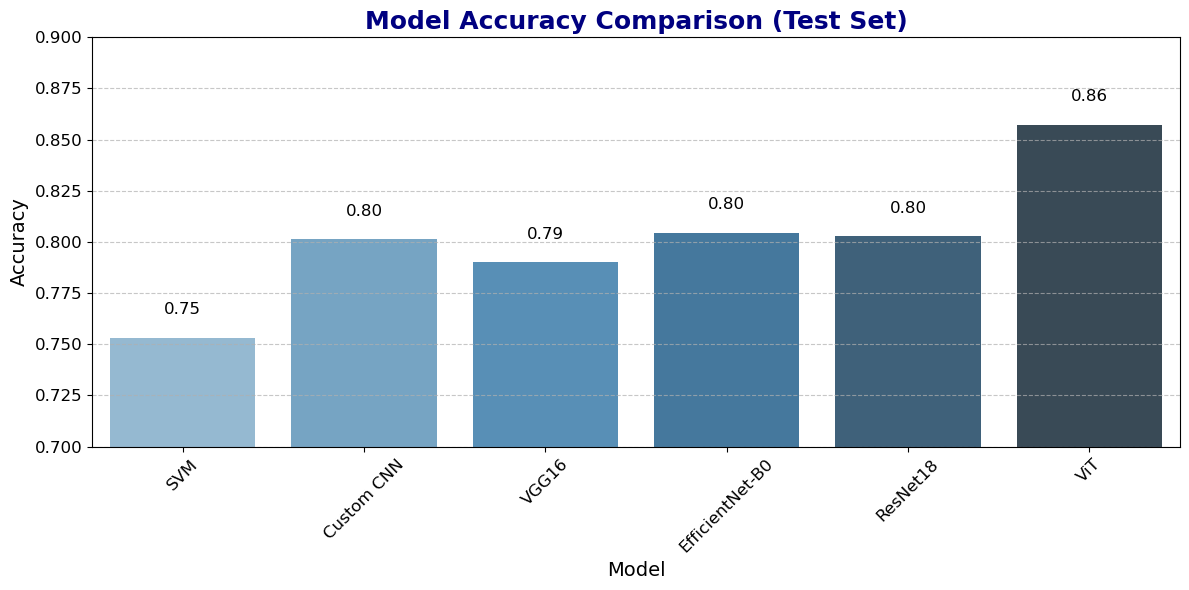

In [85]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Model', y='Accuracy', palette='Blues_d')

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels on top of each bar
for index, value in enumerate(df['Accuracy']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('Model Accuracy Comparison (Test Set)', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.7, 0.9)  # Set y-axis limits for better visibility
plt.tight_layout()
plt.show()

**Line Plot for Models Accuracy Comparison**  
* Interactive Line Plot for Models Accuracy Comparison

In [87]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

# Add line and markers
fig.add_trace(go.Scatter(x=df['Model'], y=df['Accuracy'],
                         mode='lines+markers',
                         line=dict(width=2, color='royalblue'),
                         marker=dict(size=10, color='darkblue', line=dict(width=2, color='black')),
                         name='Accuracy'))

# Fill area under the line
fig.add_trace(go.Scatter(x=df['Model'], y=df['Accuracy'],
                         mode='lines',
                         fill='tozeroy',  # Fill to zero
                         fillcolor='rgba(173, 216, 230, 0.5)',  # Light blue fill
                         line=dict(color='rgba(255, 255, 255, 0)'),  # Invisible line
                         showlegend=False))

fig.update_layout(title='Model Accuracy Comparison',
                  title_font=dict(size=20, family='Arial, sans-serif', color='navy'),
                  xaxis_title='Model',
                  yaxis_title='Accuracy',
                  yaxis=dict(range=[0.7, 0.9]),
                  xaxis_tickangle=-45,
                  template='plotly_white',
                  font=dict(size=14))

fig.show()

**Plot bar plot for training time**

In [100]:
# Convert seconds to minutes:seconds format
df['Training Time (m:s)'] = df['Training Time'].apply(lambda x: f"{int(x // 60)}:{int(x % 60):02d}")

# Create the interactive bar chart
fig = go.Figure(data=[go.Bar(
    x=df['Model'],
    y=df['Training Time'],
    text=df['Training Time (m:s)'],
    textposition='auto',
    hoverinfo='text',
    marker_color=px.colors.qualitative.Plotly
)])

fig.update_layout(
    title='Model Training Time Comparison',
    xaxis_title='Model',
    yaxis_title='Training Time (seconds)',
    font=dict(size=14)
)
fig.show()

**Plot Confusion Matrices of Models**

In [3]:
confusion_matrices = {
    'SVM': np.array([[83, 151],
                     [3, 387]]),
    'Custom CNN': np.array([[115, 119],
                             [5, 385]]),
    'VGG16': np.array([[118, 116],
                       [15, 375]]),
    'EfficientNet-B0': np.array([[113, 121],
                                  [1, 389]]),
    'ResNet18': np.array([[118, 116],
                          [7, 383]]),
    'ViT Base Patch16 224': np.array([[147, 87],
                                       [2, 388]])
}

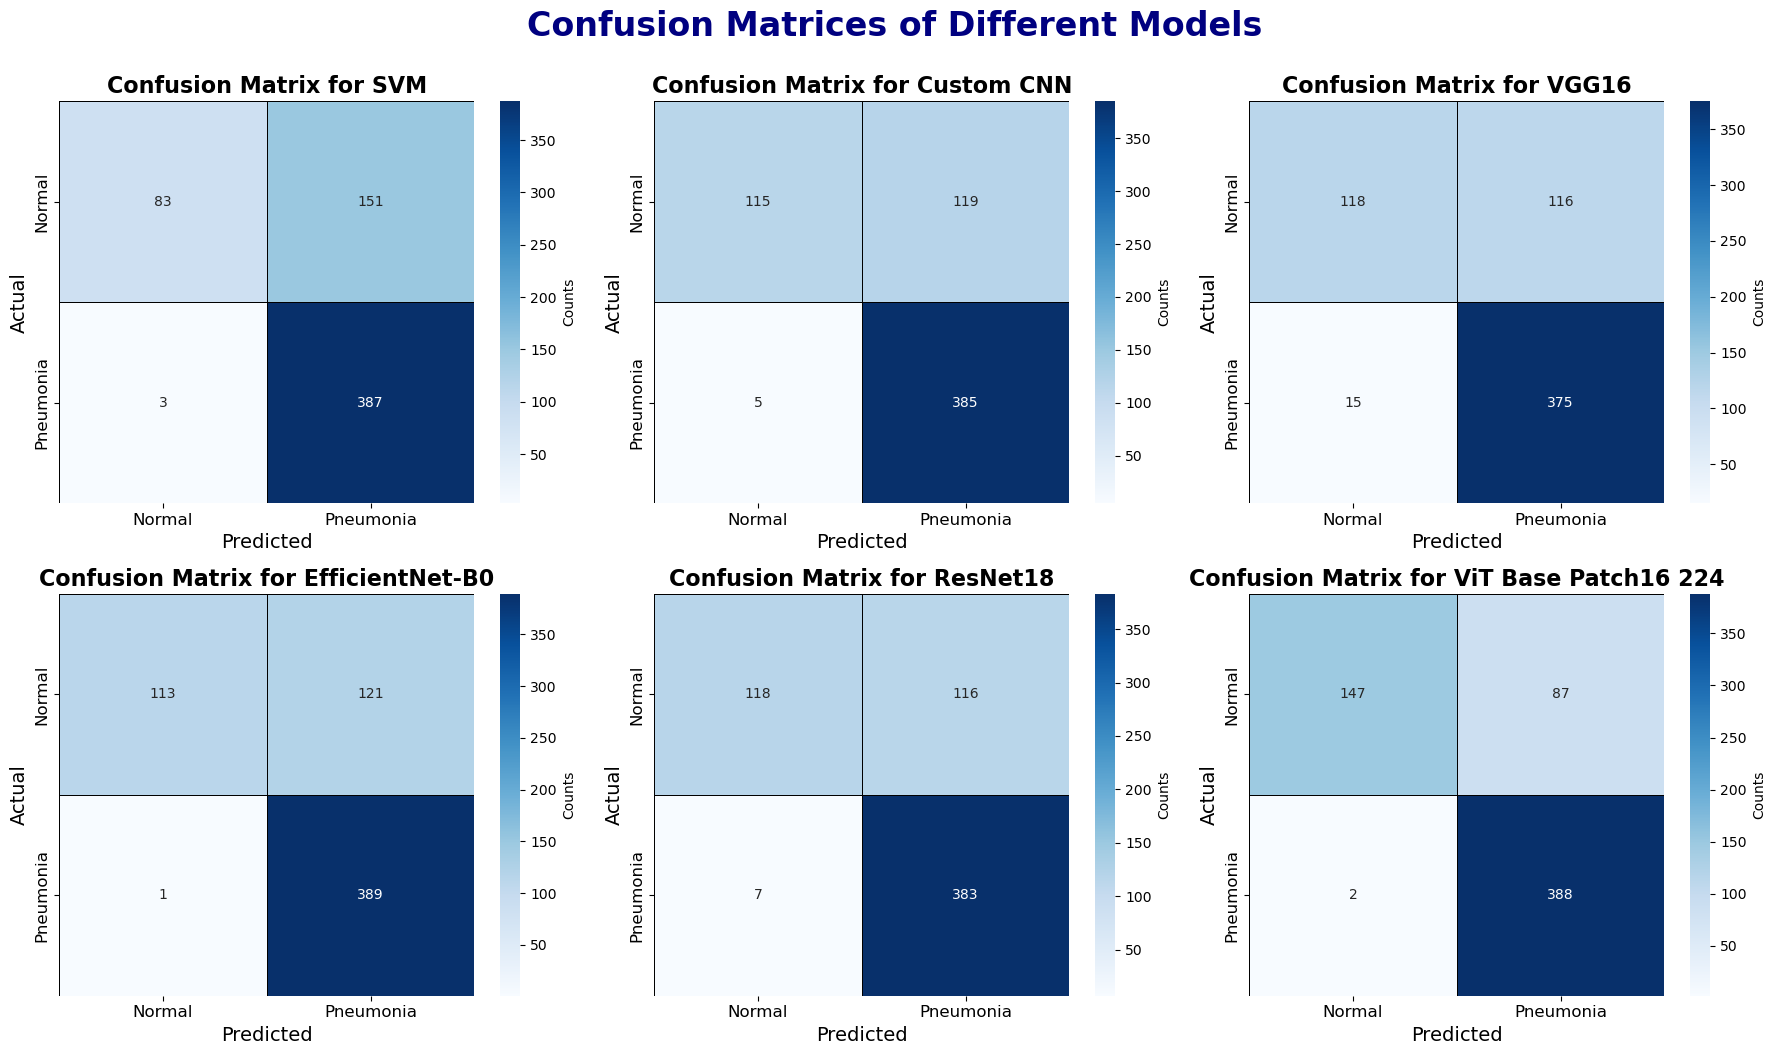

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

cmap = sns.color_palette("Blues", as_cmap=True)

# Loop through the models and their confusion matrices
for ax, (model, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                cbar=True, linewidths=0.5, linecolor='black',
                cbar_kws={'label': 'Counts', 'orientation': 'vertical'})
    
    ax.set_title(f'Confusion Matrix for {model}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=14)
    ax.set_ylabel('Actual', fontsize=14)
    ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'], fontsize=12)
    ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'], fontsize=12)
    
    ax.grid(False)  # Disable the default grid for a cleaner look

plt.tight_layout()
plt.suptitle('Confusion Matrices of Different Models', fontsize=24, fontweight='bold', y=1.05, color='navy')
plt.savefig('../content/plots/subplot_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

----